In [167]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [277]:
fees = pd.read_csv("harvard_fees.csv").iloc[:,1:].iloc[::-1].reset_index(drop=True)
fees_to_predict =  pd.read_csv("harvard_fees_to_predict.csv").iloc[::-1].reset_index(drop=True)

In [169]:
lr = LinearRegression()

In [170]:
fees.columns

Index(['Academic.Year', 'Tuition....', 'Health.Services.Fee....',
       'Student.Services.Fee....', 'Room....', 'Board....', 'Total....'],
      dtype='object')

In [171]:
fees[['Academic.Year','Total....']].head()

,Academic.Year,Total....
0,1985,14100
1,1986,15100
2,1987,16145
3,1988,17100
4,1989,18210


<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

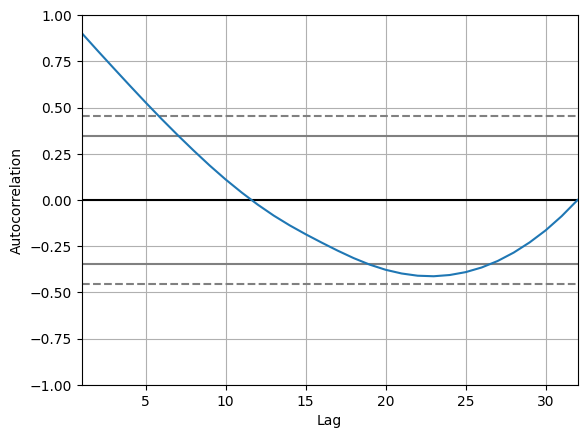

In [172]:
autocorrelation_plot(fees['Total....'])

In [ ]:
lr.fit(np.array(fees['Academic.Year']).reshape(-1,1),fees['Total....'])

In [175]:
differemces_with_lr = lr.predict(np.array(fees['Academic.Year']).reshape(-1,1))-np.array(fees['Total....'])

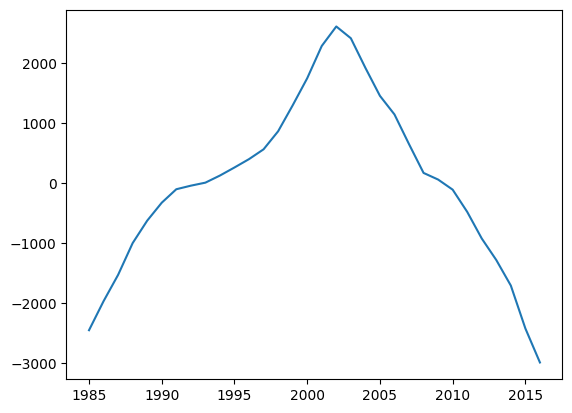

In [176]:
plt.plot(np.array(fees['Academic.Year']),differemces_with_lr)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

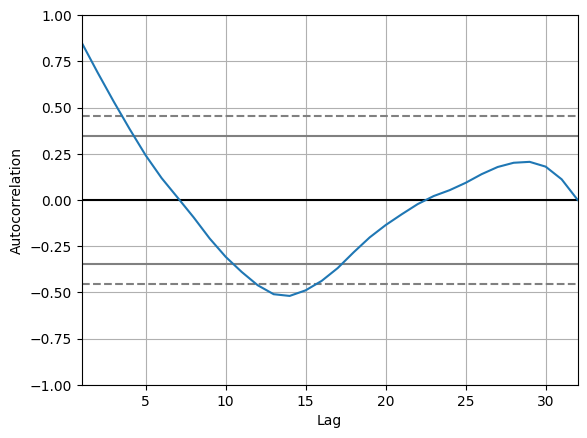

In [177]:
autocorrelation_plot(differemces_with_lr)

In [253]:
param_grid_sup_arima ={'ar': [0, 1,2,3],"i":[0,1,2], 'ma': [0, 1,2,3]}
 

In [256]:
#The (p,d,q) order of the model for the autoregressive, differences, and moving average components. 
#d is always an integer, while p and q may either be integers or lists of integers.
def grid_search_arima(series, param_grid):    
    best_model = None
    best_score = 9999999999
    best_params = None
    for ar in param_grid["ar"]:
        for i in param_grid["i"]:
            for ma in param_grid["ma"]:
                arima_model = ARIMA(series, order=(ar,i,ma))
                arima_model_fit = arima_model.fit()
                if arima_model_fit.aic < best_score:
                    best_score = arima_model_fit.aic
                    best_model = arima_model_fit
                    best_params = (ar,i,ma)
    return best_model, best_score, best_params

In [ ]:
best_model_sup_arima, best_score_sup_arima, best_params_sup_arima = grid_search_arima(differemces_with_lr,param_grid_sup_arima)

In [240]:
best_score_sup_arima, best_params_sup_arima

(388.6091752684351, (1, 2, 3))

In [241]:
print(best_model_sup_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -189.305
Date:                Thu, 25 Jan 2024   AIC                            388.609
Time:                        22:27:11   BIC                            395.615
Sample:                             0   HQIC                           390.850
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4334      0.436     -0.994      0.320      -1.288       0.421
ma.L1          1.4332      2.459      0.583      0.560      -3.386       6.253
ma.L2         -0.0503      1.414     -0.036      0.9

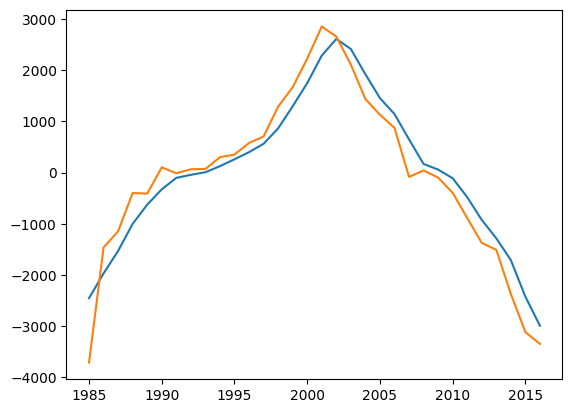

In [243]:
plt.plot(np.array(fees['Academic.Year']),differemces_with_lr)
plt.plot(np.array(fees['Academic.Year']),best_model_sup_arima.predict(1,len(fees['Academic.Year'])))


In [244]:
fused_predictions = lr.predict(np.array(fees['Academic.Year']).reshape(-1,1))+best_model_sup_arima.predict(1,len(fees['Academic.Year']))

In [254]:
param_grid_pure_arima ={'ar': [0, 1,2,3],"i":[1,2], 'ma': [0, 1,2,3]}

In [ ]:
best_model_pure_arima, best_score_pure_arima, best_params_pure_arima = grid_search_arima(fees['Total....'],param_grid_pure_arima)

In [259]:
print(best_model_pure_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Total....   No. Observations:                   32
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -193.291
Date:                Thu, 25 Jan 2024   AIC                            392.583
Time:                        22:33:10   BIC                            396.786
Sample:                             0   HQIC                           393.928
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6083      0.254      2.390      0.017       0.110       1.107
ma.L2         -0.3502      0.224     -1.560      0.119      -0.790       0.090
sigma2       1.79e+04   5705.920      3.137      0.0

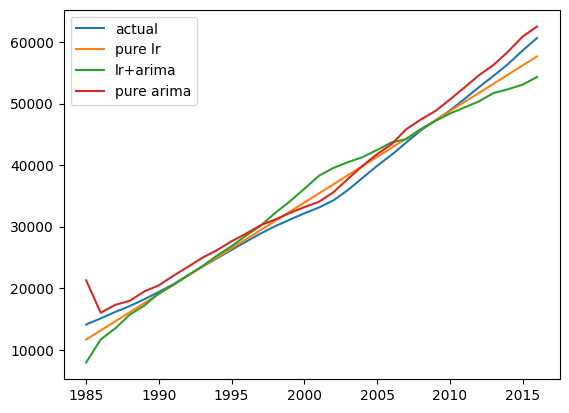

In [286]:
plt.plot(np.array(fees['Academic.Year']),np.array(fees['Total....']), label='actual')
plt.plot(np.array(fees['Academic.Year']),lr.predict(np.array(fees['Academic.Year']).reshape(-1,1)), label='pure lr')
plt.plot(np.array(fees['Academic.Year']),fused_predictions, label='lr+arima')
plt.plot(np.array(fees['Academic.Year']),best_model_pure_arima.predict(1,len(fees['Academic.Year'])), label='pure arima')
plt.legend()
plt.show()

In [261]:
loss = lambda Y, Y_pred : sum((Y-Y_pred)**2)/len(Y_pred)

In [262]:
fees_to_predict.head()

,year,total
0,2004,37928
1,2005,39880
2,2006,41675
3,2007,43655
4,2008,45620


In [269]:
loss(fees_to_predict["total"],  lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1))+best_model_sup_arima.forecast(len(fees_to_predict["year"])))

134635648.10907862

In [274]:
loss(fees_to_predict["total"], lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1)))

16281036.344892686

In [285]:
loss(fees_to_predict["total"], np.array(best_model_pure_arima.forecast(len(fees_to_predict["year"]))))

603618104.3800325

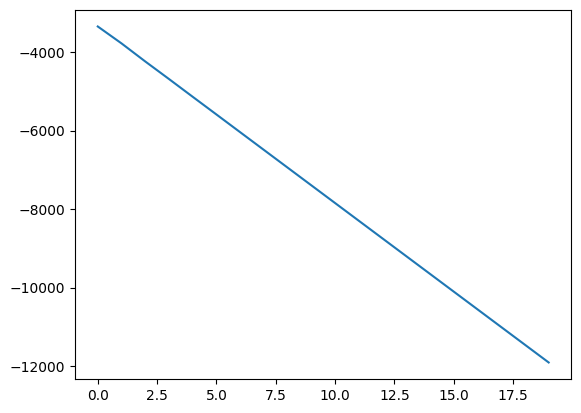

In [275]:
plt.plot(best_model_sup_arima.forecast(len(fees_to_predict["year"])))


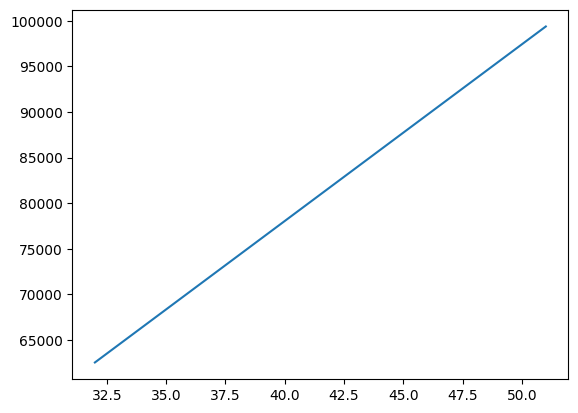

In [276]:
plt.plot(best_model_pure_arima.forecast(len(fees_to_predict["year"])))

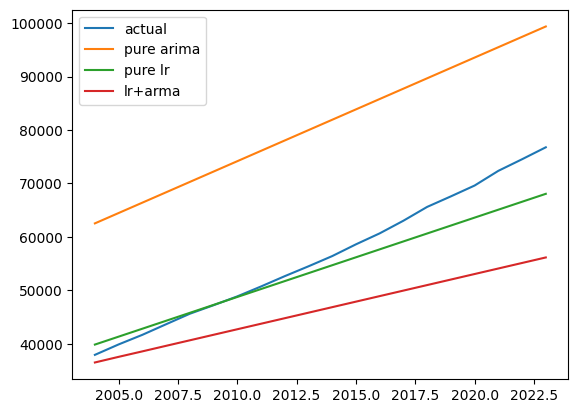

In [278]:
lr_and_arima=  lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1))+best_model_sup_arima.forecast(len(fees_to_predict["year"]))
plt.plot(fees_to_predict["year"],fees_to_predict["total"], label='actual')
plt.plot(fees_to_predict["year"],best_model_pure_arima.forecast(len(fees_to_predict["year"])), label='pure arima')
plt.plot(fees_to_predict["year"],lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1)), label="pure lr")
plt.plot(fees_to_predict["year"],lr_and_arima, label="lr+arma")
plt.legend()
plt.show()